In [28]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )


In [29]:
gene_info               = fread("input/phenotypes/gene_info.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
isof_info               = fread("input/phenotypes/isoform_info.txt", sep = "\t", header = TRUE, data.table = FALSE)
gene_info$transcript_id = gene_info$gene_id
promoters               = fread("/frazer01/reference/private/Gencode.v34lift37/promoters.bed", sep = "\t", header = FALSE, data.table = FALSE)


In [30]:
diffexp         = fread("pipeline/4.1.differential_expression/diffexp.txt", sep = "\t", header = TRUE, data.table = FALSE)


In [32]:
tmpwd = "pipeline/5.1.expression_enrichments/stage_enrichment_vs_bg"
dir.create(tmpwd, showWarnings = FALSE)

In [44]:
tissues = unique(diffexp[,c("tissue1", "tissue2")])

tissues

,tissue1,tissue2
,<chr>,<chr>
1,ipsc_cvpc,heart
130468,ipsc_cvpc,arteria
260935,heart,arteria


In [34]:
str(diffexp)

'data.frame':	391401 obs. of  18 variables:
 $ transcript_id: chr  "ENSG00000000003.15_5" "ENSG00000000005.6_4" "ENSG00000000419.12_6" "ENSG00000000457.14_7" ...
 $ gene_id      : chr  "ENSG00000000003.15_5" "ENSG00000000005.6_4" "ENSG00000000419.12_6" "ENSG00000000457.14_7" ...
 $ gene_name    : chr  "TSPAN6" "TNMD" "DPM1" "SCYL3" ...
 $ gene_type    : chr  "protein_coding" "protein_coding" "protein_coding" "protein_coding" ...
 $ beta         : num  1.808 1.748 0.672 1.736 1.804 ...
 $ se           : num  0.105 0.106 0.143 0.121 0.114 ...
 $ tval         : num  17.27 16.49 4.69 14.3 15.89 ...
 $ pval         : num  1.18e-54 8.81e-51 3.36e-06 3.32e-40 8.28e-48 ...
 $ qval         : num  2.40e-50 1.80e-46 6.84e-02 6.76e-36 1.69e-43 ...
 $ tissue1      : chr  "ipsc_cvpc" "ipsc_cvpc" "ipsc_cvpc" "ipsc_cvpc" ...
 $ tissue2      : chr  "heart" "heart" "heart" "heart" ...
 $ type         : chr  "gene_tpm" "gene_tpm" "gene_tpm" "gene_tpm" ...
 $ diffexp      : logi  TRUE TRUE FALSE TRUE TRUE

In [35]:
run_homer_tissue = function(tissue, type, name, genes, diffexp, isof_info, promoters)
{
    diffexp_genes         = diffexp[diffexp$type == type & diffexp$diffexp == TRUE, "transcript_id"]
    diffexp_genes         = unique(diffexp[diffexp$type == type & !diffexp$transcript_id %in% diffexp_genes, "transcript_id"])
    isoforms              = promoters[ promoters[,4] %in% isof_info[ isof_info$gene_id %in% genes         | isof_info$transcript_id %in% genes        , "transcript_id"],]
    isoforms_bg           = promoters[ promoters[,4] %in% isof_info[ isof_info$gene_id %in% diffexp_genes | isof_info$transcript_id %in% diffexp_genes, "transcript_id"],]
    colnames(isoforms   ) = c("chrom", "from", "to", "transcript_id")
    colnames(isoforms_bg) = c("chrom", "from", "to", "transcript_id")
    isoforms              = merge(isoforms   , isof_info[,c("transcript_id", "strand")])
    isoforms_bg           = merge(isoforms_bg, isof_info[,c("transcript_id", "strand")])
    isoforms   $score     = 0
    isoforms_bg$score     = 0
    isoforms              = isoforms   [order(isoforms   [,"chrom"], isoforms   [,"from"], isoforms   [,"to"]),]
    isoforms_bg           = isoforms_bg[order(isoforms_bg[,"chrom"], isoforms_bg[,"from"], isoforms_bg[,"to"]),]
    analysis_name         = paste(name, tissue,       sep = ".")
    bg_name               = paste(name, tissue, "bg", sep = ".")
    bed_file              = paste(tmpwd, paste(analysis_name,             "bed", sep = "."), sep = "/")
    bed_file_bg           = paste(tmpwd, paste(bg_name      ,             "bed", sep = "."), sep = "/")
    bed_file_bg_unmerged  = paste(tmpwd, paste(bg_name      , "unmerged", "bed", sep = "."), sep = "/")
    bed_file_unmerged     = paste(tmpwd, paste(analysis_name, "unmerged", "bed", sep = "."), sep = "/")
    motif_file            = "/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_HUMAN_mono_homer_format_0.0001.motif"

    fwrite(isoforms   [,c("chrom", "from", "to", "transcript_id", "score", "strand")], bed_file_unmerged   , sep = "\t", col.names = FALSE, row.names = FALSE)
    fwrite(isoforms_bg[,c("chrom", "from", "to", "transcript_id", "score", "strand")], bed_file_bg_unmerged, sep = "\t", col.names = FALSE, row.names = FALSE)
    
    system(paste("bedtools merge -c 4 -o distinct", "-i", bed_file_unmerged   , ">", bed_file   ))
    system(paste("bedtools merge -c 4 -o distinct", "-i", bed_file_bg_unmerged, ">", bed_file_bg))
    
    command = paste("findMotifsGenome.pl", bed_file, "hg19", paste(tmpwd, analysis_name, sep = "/"), 
                    "-mknown" , motif_file, 
                    "-mcheck" , motif_file, 
                    "-bg"     , bed_file_bg,
                    "-nomotif", 
                    "-size"   , 200,
                    ""
                   )
    
    return(command)
}

enrichment_epigenome = function(diffexp, tissue1, tissue2, type, isof_info, promoters)
{
    message(paste(tissue1, tissue2, type))
    
    x  = diffexp[diffexp$type == type & diffexp$tissue1 == tissue1 & diffexp$tissue2 == tissue2 & diffexp$diffexp == TRUE, ]
    
    dif1 = x[x$beta > 0,]
    dif2 = x[x$beta < 0,]
    
    out     = c(run_homer_tissue(tissue1, type, paste(type, tissue1, tissue2, sep = "."), unique(dif1$transcript_id), diffexp, isof_info, promoters),
                run_homer_tissue(tissue2, type, paste(type, tissue1, tissue2, sep = "."), unique(dif2$transcript_id), diffexp, isof_info, promoters),
                "")
    return(out)
}

to_run = unlist(lapply(1:nrow(tissues), function(ii)
{
    tissue1 = tissues[ii, "tissue1"]
    tissue2 = tissues[ii, "tissue2"]
    
    out2 = unlist(lapply(c("gene_tpm", "isoform_use"), function(type)
    {
        enrichment_epigenome(diffexp, tissue1, tissue2, type, isof_info, promoters)
    }))
    return(out2)
}))


ipsc_cvpc heart gene_tpm

ipsc_cvpc heart isoform_use

ipsc_cvpc arteria gene_tpm

ipsc_cvpc arteria isoform_use

heart arteria gene_tpm

heart arteria isoform_use



In [37]:
shfile = paste(tmpwd, "run_homer.sh", sep = ".")
writeLines(to_run, con = shfile, sep = "\n")

message(paste("bash", shfile))
message(paste("nohup", "bash", shfile, "&"))

bash pipeline/5.1.expression_enrichments/stage_enrichment_vs_bg.run_homer.sh

nohup bash pipeline/5.1.expression_enrichments/stage_enrichment_vs_bg.run_homer.sh &



# Once Homer is run

In [39]:
motifs           = fread("/frazer01/reference/public/hocomoco_v11/HOCOMOCOv11_core_annotation_HUMAN_mono.tsv", sep = "\t", header = TRUE, data.table = FALSE)
motifs$gene_name = motifs[, "Transcription factor"]
colnames(motifs) = gsub(" ", "_", tolower(colnames(motifs)))


In [60]:
#tissues = c("ipsc_cvpc", "heart", "arteria")
cells   = sort(unique(diffexp$cell_type))
enr     = lapply(1:nrow(tissues), function(ii)
{
    tissue1 = tissues[ii, "tissue1"]
    tissue2 = tissues[ii, "tissue2"]
    
    out1 = lapply(c(tissue1, tissue2), function(tissue3)
    {
        types = c("gene_tpm", "isoform_use")
        out2 = lapply(types, function(type)
        {
            infile           = paste(tmpwd, paste(type, tissue1, tissue2, tissue3, sep = "."), "knownResults.txt", sep = "/")
            if(file.exists(infile) == TRUE)
            {
                tf_up            = fread(infile, sep = "\t", header = TRUE, data.table = FALSE)
                colnames(tf_up)  = c("model", "consensus", "pval", "logp", "qval", "in_n", "in_p", "out_n", "out_p")
                tf_up$in_p       = as.numeric(gsub("%", "", tf_up$in_p ))
                tf_up$out_p      = as.numeric(gsub("%", "", tf_up$out_p))
                tf_up$log2r      = log2(tf_up$in_p / tf_up$out_p)
                tf_up            = merge(motifs[,c("model", "gene_name", "quality", "tf_family", "tf_subfamily")], tf_up, by = "model")

                return(tf_up)
            }
        })
        names(out2) = types
        return(out2)
    })
    names(out1) = c(tissue1, tissue2)

    return(out1)
})

names(enr) = paste(tissues$tissue1, tissues$tissue2, sep = ".")
saveRDS(enr, paste(tmpwd, "enrichment_cell_types.rds"))

In [61]:
suppressPackageStartupMessages(library(wordcloud))
suppressPackageStartupMessages(library(tm))

source("script/colors.R"    )


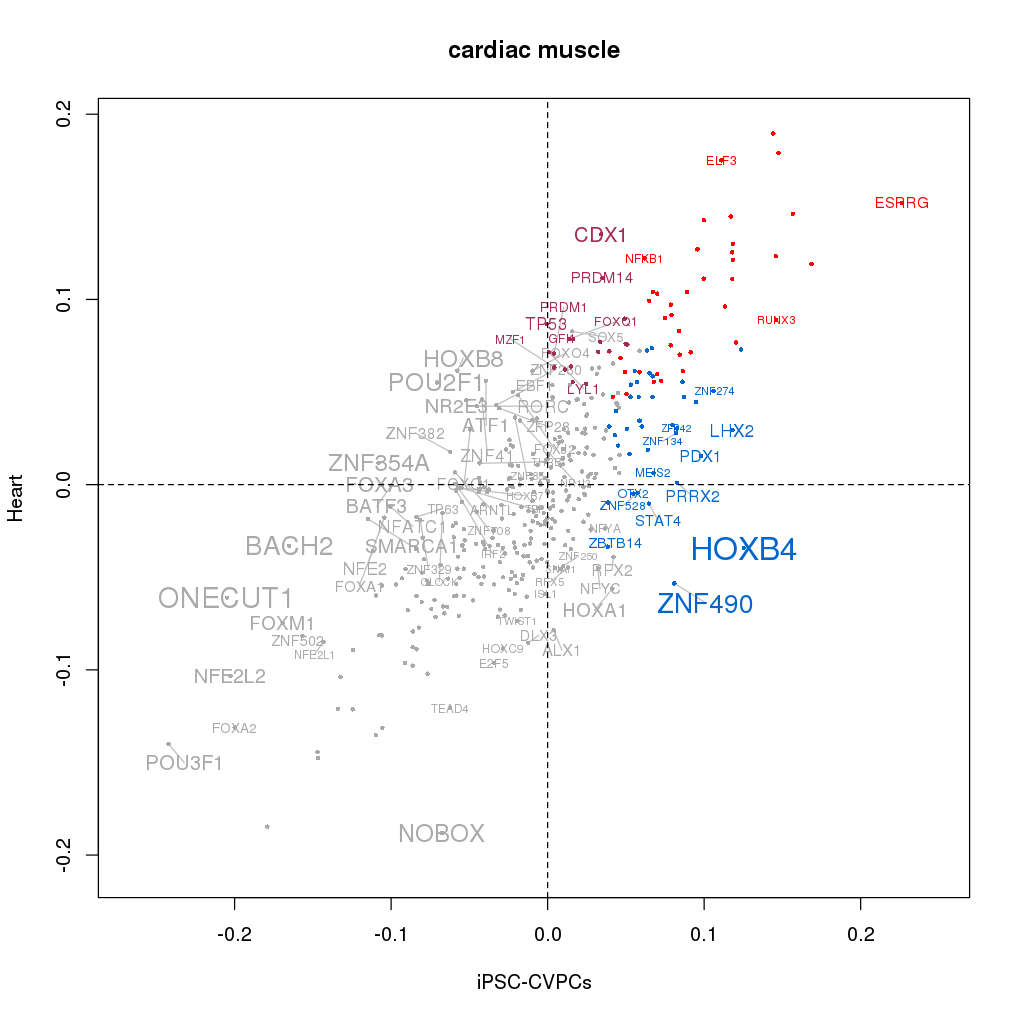

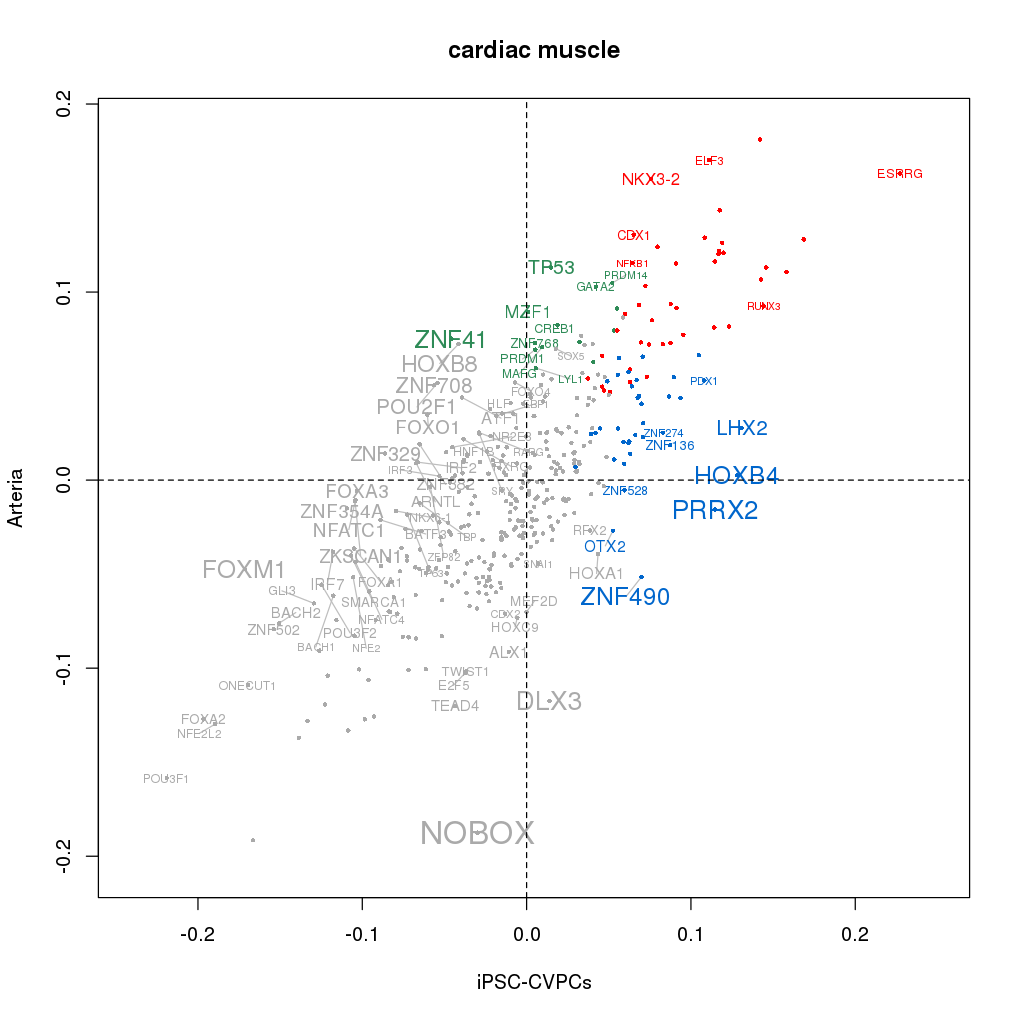

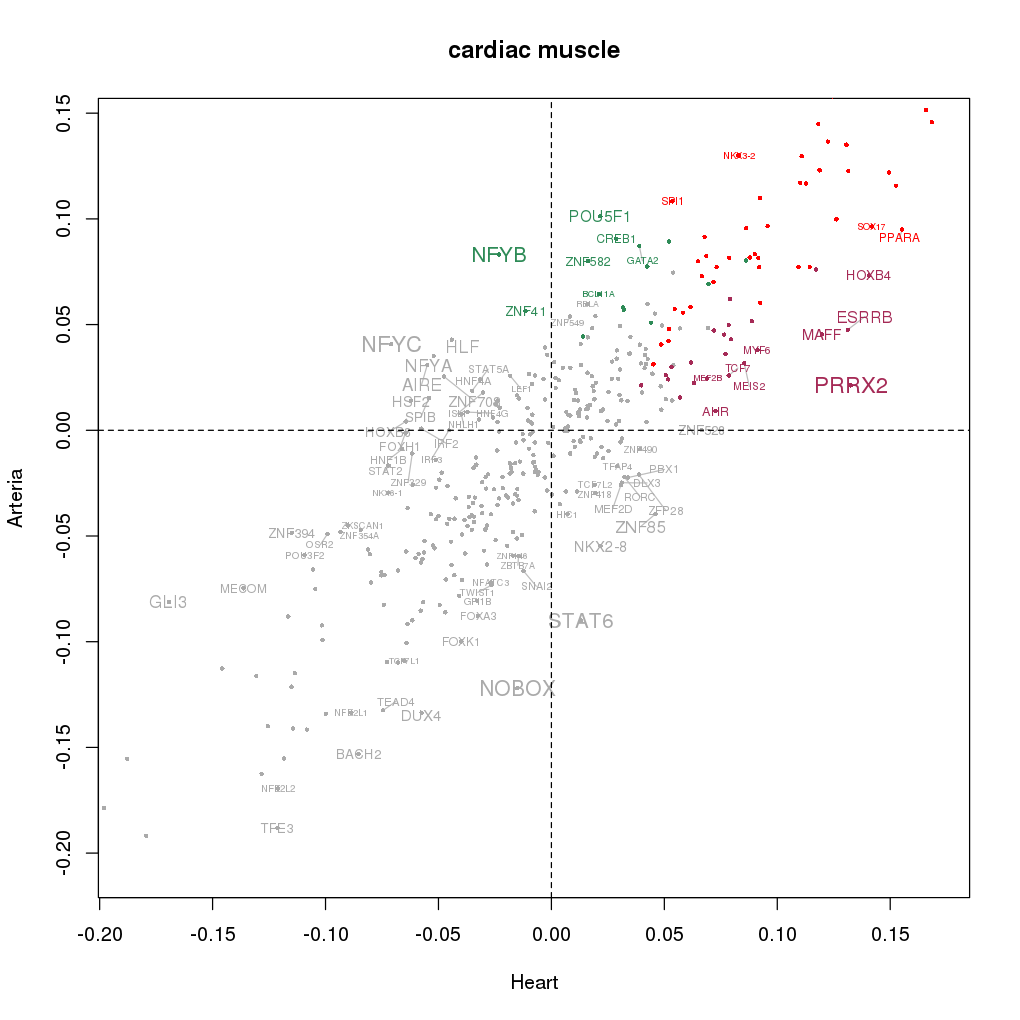

In [63]:
plot_homer = function(tissue1, tissue2, type, enr)
{
    inlist    = enr[[paste(tissue1, tissue2, sep = ".")]]
    tfs       = merge(inlist[[tissue1]][[type]], inlist[[tissue2]][[type]][,c("model", "pval", "logp", "qval", "in_n", "in_p", "out_n", "out_p", "log2r")], by = "model", suffixes = 1:2)
    tfs$delta = tfs$log2r1 - tfs$log2r2
    tfs       = tfs[order(tfs$delta),]
    tfs$color = "#aaaaaa"
    tfs[tfs$qval1 <= 0.05 & tfs$qval2 <= 0.05, "color"] = "#ff0000"
    tfs[tfs$qval1 <= 0.05 & tfs$qval2 >  0.05, "color"] = tissue2color3[tissue1, "color"]
    tfs[tfs$qval1 >  0.05 & tfs$qval2 <= 0.05, "color"] = tissue2color3[tissue2, "color"]
    
    #toplot  = tfs[tfs$color != "#aaaaaa",]
    toplot  = tfs[abs(tfs$delta) > quantile(abs(tfs$delta), probs = 0.8),]
    
    textplot(toplot$log2r1, toplot$log2r2, toplot$gene_name, cex = abs(toplot$delta)*10, col = toplot$color, xlim = range(toplot$log2r1) * 1.1, ylim = range(toplot$log2r2) * 1.1, xlab = tissue2color3[tissue1, "body_site"], ylab = tissue2color3[tissue2, "body_site"], main = gsub("_", " ", cell))
    points  (tfs   $log2r1, tfs   $log2r2, col = tfs$color, pch = 16, cex = 0.5)
    #plot(tfs$log2r1, tfs$log2r2, pch = 16, col = tfs$color)
    #
    #toplot = tfs[tfs$color != "#aaaaaa", ]
    #toplot = rbind(head(toplot, n = 5), tail(toplot, n = 5))
    abline(h = 0, lty = "dashed", col = "#000000")
    abline(v = 0, lty = "dashed", col = "#000000")
    #
    #text(x = toplot$log2r1, y = toplot$log2r2, labels = toplot$gene_name, pos = 3)
}

tissue1 = "ipsc_cvpc"
tissue2 = "heart"
cell    = "cardiac_muscle"

options(repr.plot.width = 8.5, repr.plot.height = 8.5)

plot_homer("ipsc_cvpc", "heart"  , "gene_tpm"   , enr)
plot_homer("ipsc_cvpc", "arteria", "gene_tpm"   , enr)
plot_homer("heart"    , "arteria", "gene_tpm"   , enr)

#options(repr.plot.width = 15, repr.plot.height = 15)
#layout(matrix(1:9, nrow = 3, byrow = TRUE))
#invisible(lapply(gsub("cibersort.regular\\.", "", cells), function(cell){plot_homer(tissue1, tissue2, cell, enr)}))
